# Calibrating the parameters - According to Section 3.1 Calibration Methodology

## Setting up paths

In [1]:
import sys
from pathlib import Path
#Set root to be the main project folder
#Note that this notebook is in /SOCIAL_DISTANCING/CODE/NOTEBOOKS/TEST_NOTEBOOKS
root = Path.cwd().parent.parent
print(root)
py_path = Path(root/'code/py-files')
print(py_path)
data_path = Path(root/'static')
print(data_path)
#Add location of py files to path so we can import
sys.path.insert(0,str(py_path))

/home/gnacikm/Documents/GitHub/cvals_new/BSIRS_final
/home/gnacikm/Documents/GitHub/cvals_new/BSIRS_final/code/py-files
/home/gnacikm/Documents/GitHub/cvals_new/BSIRS_final/static


# Importing Libraries

In [2]:
import os
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from importlib import reload
from tqdm import tqdm
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.patches as mpatches
import exposure_matrix as mat
import execute_system as exe_sys
import plotting
from helper_fun import finding_best

## Imporing Files

In [3]:
utla_folder = Path(data_path/'utla_data/')

In [4]:
gdf_covid =  gpd.read_file(utla_folder/"shp/covid-cases_EN_recent.shp")
df_pops = pd.read_csv(utla_folder/'csv/population.csv')
gdf_utla_names = gpd.read_file(utla_folder/"shp/UTLA_ENG.shp")

In [5]:
df_mob = pd.read_csv(utla_folder/'csv/mob_trends.csv', low_memory=False)

In [22]:
gdf_covid

,UTLA19CD,UTLA19NAME,2020-07-01,2020-07-11,2020-07-21,2020-07-31,2020-08-10,2020-08-20,2020-08-30,2020-09-09,...,2020-11-28,2020-12-08,2020-12-18,2020-12-28,2021-01-07,2021-01-17,2021-01-27,2021-02-06,2021-02-16,geometry
0,E06000001,Hartlepool,3.0,11.0,14.0,10.0,12.0,18.0,78.0,78.0,...,321.0,425.0,693.0,1121.0,626.0,459.0,313.0,238.0,214.0,"POLYGON ((450022.099 526039.600, 449679.001 52..."
1,E06000002,Middlesbrough,8.0,11.0,7.0,46.0,32.0,55.0,106.0,83.0,...,391.0,450.0,564.0,1311.0,896.0,904.0,710.0,620.0,359.0,"POLYGON ((453314.913 515472.255, 454376.905 51..."
2,E06000003,Redcar and Cleveland,3.0,4.0,6.0,0.0,12.0,37.0,60.0,48.0,...,278.0,278.0,334.0,934.0,727.0,732.0,459.0,371.0,215.0,"MULTIPOLYGON (((455004.100 526954.301, 454906...."
3,E06000004,Stockton-on-Tees,9.0,7.0,11.0,16.0,9.0,33.0,83.0,99.0,...,473.0,700.0,750.0,1383.0,1122.0,980.0,737.0,571.0,402.0,"MULTIPOLYGON (((450276.202 525921.701, 450138...."
4,E06000005,Darlington,2.0,4.0,6.0,3.0,4.0,13.0,29.0,38.0,...,313.0,273.0,402.0,751.0,505.0,490.0,304.0,292.0,228.0,"POLYGON ((430852.381 510073.154, 430509.720 50..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,E10000029,Suffolk,21.0,25.0,36.0,37.0,39.0,47.0,109.0,93.0,...,924.0,1963.0,2934.0,5776.0,4075.0,2707.0,1434.0,740.0,611.0,"MULTIPOLYGON (((637603.601 244455.900, 637399...."
147,E10000030,Surrey,67.0,44.0,65.0,81.0,154.0,179.0,333.0,231.0,...,2564.0,5739.0,9501.0,13099.0,8272.0,5278.0,2951.0,1621.0,962.0,"POLYGON ((537686.001 139615.906, 536169.966 13..."
148,E10000031,Warwickshire,50.0,36.0,58.0,49.0,64.0,45.0,150.0,266.0,...,1081.0,1737.0,2093.0,3706.0,2839.0,2214.0,1506.0,1159.0,954.0,"POLYGON ((433693.311 236453.095, 432857.313 23..."
149,E10000032,West Sussex,31.0,56.0,36.0,27.0,70.0,71.0,211.0,148.0,...,923.0,2284.0,4544.0,8984.0,5928.0,3994.0,2214.0,1241.0,921.0,"MULTIPOLYGON (((477097.801 100785.999, 477062...."


In [6]:
london_utlas = np.arange(92,125)

In [7]:
gdf_covid_per1000_bf = gdf_covid.loc[:, "2020-09-29":'2020-12-28'].divide(df_pops["population"], axis=0)*1000
sel_dates = ["2020-09-29", "2020-10-29", "2020-11-28", "2020-12-28"] 	
gdf_covid_per1000 = gdf_covid_per1000_bf.loc[:,sel_dates]
gdf_covid_per1000["geometry"] = gdf_covid.geometry.copy()

## Setting up system parameters

In [8]:
reload(mat)
pops = df_pops.population 
sigma = 10000
sys1 = mat.WMATRIX(gdf_covid.geometry, pops, sigma=sigma)
W = sys1.make_exposure_mat()
L = gdf_covid.geometry.size
tau = 3.0
initial_infected = gdf_covid["2020-09-29"].fillna(0.0)
length = gdf_covid.geometry.size

In [9]:
c_vals = np.random.uniform(1, 5, size=L)
sir_params = [0.35, 0.1, 0.007]

In [10]:
model_params = {}
model_params['W'] = W
model_params['pops'] = pops
model_params["SIR parameters"] = sir_params
model_params["tau"] = tau
model_params["initial_infected"] = initial_infected
model_params["length"] = length

# Testing the BSIRS model - initiating the system

In [11]:
s_vals, i_vals, u_vals = exe_sys.initiate_system_single(
    model_params,
    c_vals
)

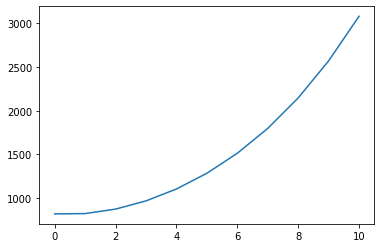

In [12]:
plt.plot(np.arange(i_vals.shape[0]),i_vals.mean(axis=1))
plt.show()

## Setting up other parameters required for calibration

In [13]:
data_to_fit = gdf_covid.iloc[:,11:-6].copy().fillna(0)

In [14]:
data_to_fit = gdf_covid.iloc[:,11:-6].copy().fillna(0)
data_to_fit = np.array(data_to_fit.transpose())

In [15]:
time_slots = data_to_fit.shape[0]

In [16]:
optimizer_params = {}
optimizer_params["optimizer"] = "momentum"
optimizer_params["mu"] = 0.82
optimizer_params["learning rate"] = 1e-04

In [17]:
beta_vals = np.arange(1.,5.)
beta_vals

array([1., 2., 3., 4.])

In [18]:
full_list = np.arange(0.0, 20.5, 0.5)

In [19]:
selected_list_betas = [0.5]

## Generating results and saving them to the files

In [21]:
for beta_val in selected_list_betas:
    print("------------------------------")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print(f"beta is {beta_val}")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("------------------------------")
    for lam_val in full_list:
        print("############################")
        print(f"lam value is {lam_val}")
        print("############################")
        pops = df_pops.population
        initial_infected = gdf_covid["2020-09-29"].fillna(0.0)
        data_to_fit = gdf_covid.iloc[:,11:-1].copy().fillna(0)
        data_to_fit = np.array(data_to_fit.transpose())
        model_params = {}
        model_params['W'] = W
        model_params['pops'] = pops
        model_params["SIR parameters"] = sir_params
        model_params["tau"] = tau
        model_params["initial_infected"] = initial_infected
        model_params["length"] = length
        c_array = np.array([np.full(L, 1.3) for k in range(time_slots-1)])
        score_array = np.full(time_slots -1, 1e+10)
        infected_array = np.array([np.full(L, 10) for k in range(time_slots-1)])
        suct_array = np.array([pops - np.full(L, 10) for k in range(time_slots-1)])
        u_array = np.array([np.full(L, 0.5) for k in range(time_slots-1)])
        result_params = {}
        result_params["c"] = c_array 
        result_params["beta"] = beta_val
        result_params["score"] = score_array
        result_params["infected"] = infected_array 
        result_params["susceptibles"] = suct_array 
        result_params["u values"] = u_array
        result_params["time slots"] = time_slots  
        reload(exe_sys)
        result_params1 = exe_sys.calibrate(
        data_to_fit, 
        result_params, 
        model_params,
        optimizer_params,
        alpha=lam_val, 
        num_trials=2000, 
        score_type="regular neighbours"
        )
        c_array = result_params1["c"] 
        score_array = result_params1["score"] 
        infected_array = result_params1["infected"]
        suct_array = result_params1["susceptibles"]
        u_array = result_params1["u values"]
        df_c_vals = pd.DataFrame(np.array(c_array).transpose())
        df_score = pd.DataFrame(np.array(score_array).transpose())
        df_infected = pd.DataFrame(np.array(infected_array).transpose())
        df_suct = pd.DataFrame(np.array(suct_array).transpose())
        df_u_vals = pd.DataFrame(np.array(u_array).transpose())
        #beta1_val  = np.round(beta1_val, 2) 
        lam_val = np.round(lam_val, 1)
        beta = beta_val
        make_path = data_path/ f"saved_params/beta_{beta}_lam_{lam_val}_sim"
        try:
            make_path.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print("Folder is already there")
        else:
            print("Folder was created")
        df_c_vals.to_csv(make_path/f"optimal_params_c_vals_lam_is_{lam_val}.csv", index=False)
        df_score.to_csv(make_path/f"optimal_params_score_lam_is_{lam_val}.csv", index=False)
        df_infected.to_csv(make_path/f"optimal_params_infected_lam_is_{lam_val}.csv", index=False)
        df_suct.to_csv(make_path/f"optimal_params_suct_beta_is_lam_is_{lam_val}.csv", index=False)
        df_u_vals.to_csv(make_path/f"optimal_params_u_vals_lam_is_{lam_val}.csv", index=False)
        print("saved")   
        print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
        print("end of iteration")
        print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")